***DeadLine - 10.10.2024 23:59***

### ЛР. Часть I: Делаем спамкилерра (1 points)

__В этом ноутбуке__ вы создадите алгоритм, который классифицирует комментарии в социальных сетях на нормальные и токсичные.

Как и во многих других реальных случаях, у вас есть только небольшой (10^3) набор данных из помеченных вручную примеров для работы. Мы будем решать эту задачу, используя как классику NLP, так и подход, основанный на эмбеддингах

comments.tsv - можно получить по ссылке https://disk.yandex.ru/d/Lf2ImAdQSLmI7w

In [25]:
%pip install pandas matplotlib scikit-learn nltk numpy torch

%matplotlib inline

import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]


,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [27]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Примечание:__ как правило, лучшей практикой является разделение данных на train/test перед тем, как с ними что-то делать.

Потому что тогда вы значительно снижаете риск дата лика


### Preprocessing and tokenization

Комментарии содержат необработанный текст с пунктуацией, заглавными/прописными буквами и даже символами новой строки.

Чтобы упростить все дальнейшие действия, мы разобьем текст на токены, разделенные пробелами, с помощью одного из токенизаторов nltk.

In [28]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [29]:
# task: preprocess each comment in train and test

texts_train = [preprocess(line) for line in texts_train]
texts_test = [preprocess(line) for line in texts_test]

In [30]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

Один из классических подходов к снаряду - использование мешка слов:
1. создайте словарь часто встречающихся слов (используйте только обучающие данные)
2. считайте это количество признаком для некоторого классификатора.

Примечание:__ на практике вы можете вычислить такие признаки с помощью sklearn. Однако это запрещено в текущем задании.
* из `sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [31]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
import numpy as np
from collections import Counter
k = 10000

token_counts = Counter()
for text in texts_train:
    tokens = text.split()
    token_counts.update(tokens)
bow_vocabulary = [token for token, _ in token_counts.most_common(k)]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [32]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    tokens = text.split()
    counts = Counter(tokens)

    # Порядок должен соответствовать bow_vocabulary
    vector = [counts.get(token, 0) for token in bow_vocabulary]

    return np.array(vector, 'float32')

In [33]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [34]:
k_max = len(set(' '.join(texts_train).split()))
print(k_max)
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

5707


__Naive Bayes:__ возможно, самая простая модель, которая может решить вашу проблему, - это так называемый классификатор Naive Bayes.

Если вы не помните математику, лежащую в основе Naive Bayes - посмотрите лекцию / загуглите

In [35]:
import numpy as np

class BinaryNaiveBayes:
    """
    Двоичный наивный байесовский классификатор для bag-of-words.
    Класс 0 — negative, класс 1 — positive.
    """
    def __init__(self, delta: float = 1.0):
        # Лапласово сглаживание
        self.delta = delta

    def fit(self, X: np.ndarray, y: np.ndarray) -> "BinaryNaiveBayes":
        n_samples, vocab_size = X.shape

        # 1) Априорные p(y)
        sum_pos = np.sum(y == 1)
        sum_neg = n_samples - sum_pos
        self.p_y = np.array([sum_neg / n_samples, sum_pos / n_samples])

        # 2) Считаем вхождения слов
        counts_pos = X[y == 1].sum(axis=0)  # [vocab_size]
        counts_neg = X[y == 0].sum(axis=0)

        # 3) Берём общее число слов в каждом классе
        total_pos_words = counts_pos.sum()
        total_neg_words = counts_neg.sum()

        # 4) Лапласово сглаживание и нормировка так, чтобы суммы были =1
        self.p_x_given_positive = (
            counts_pos + self.delta
        ) / (total_pos_words + self.delta * vocab_size)

        self.p_x_given_negative = (
            counts_neg + self.delta
        ) / (total_neg_words + self.delta * vocab_size)

        return self

    def predict_scores(self, X: np.ndarray) -> np.ndarray:
        """
        Лог-скоры пропорциональны log p(x,y=k).
        Возвращает массив формы [n_samples, 2]: колонки — класс 0 и класс 1.
        """
        log_pos = np.log(self.p_x_given_positive)
        log_neg = np.log(self.p_x_given_negative)

        # score_neg = log p(y=0) + sum_i x_i * log p(x_i|y=0)
        score_neg = X @ log_neg + np.log(self.p_y[0])
        # score_pos = log p(y=1) + sum_i x_i * log p(x_i|y=1)
        score_pos = X @ log_pos + np.log(self.p_y[1])

        return np.stack([score_neg, score_pos], axis=-1)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Выдаёт метки {0,1} по максимальному лог-ску.
        """
        scores = self.predict_scores(X)
        return np.argmax(scores, axis=-1)

In [36]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [37]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = bow_vocabulary.index('fuck')  # offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good')  # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.756
Well done!


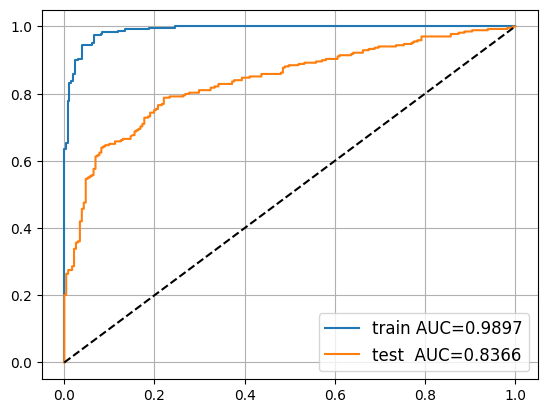

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Итак, он определенно чему-то научился. Теперь давайте выясним, что именно он узнал. Проще всего это сделать, выделив слова с наибольшими вероятностями при условии определенного класса.

Ваша задача - вычислить топ-25 слов, которые имеют __наибольшее__ соотношение ${p(x_i | y=1)} \over {p(x_i | y=0)}$. Наслаждайтесь!

In [39]:
# hint: use naive_model.p_*
probability_ratio = naive_model.p_x_given_negative / naive_model.p_x_given_positive
top_indices = np.argsort(probability_ratio)[::][:25]
top_negative_words = [bow_vocabulary[i] for i in top_indices]

assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]})")

#0	    hitler	(ratio=0.002103166887536645)
#1	      heil	(ratio=0.002119512762874365)
#2	   offfuck	(ratio=0.00226629339158535)
#3	      suck	(ratio=0.0031772113870829344)
#4	    nigger	(ratio=0.004470666404813528)
#5	 j.delanoy	(ratio=0.004545177333056927)
#6	      dick	(ratio=0.005347267724573612)
#7	      fggt	(ratio=0.010226649232208729)
#8	     bitch	(ratio=0.016696568578481674)
#9	      fuck	(ratio=0.018593907356262207)
#10	      slap	(ratio=0.02272588573396206)
#11	      shit	(ratio=0.02272588573396206)
#12	   fucking	(ratio=0.031466614454984665)
#13	       ass	(ratio=0.037187814712524414)
#14	    stupid	(ratio=0.05454212799668312)
#15	         =	(ratio=0.05701268091797829)
#16	   college	(ratio=0.05843799188733101)
#17	         *	(ratio=0.05843799188733101)
#18	   asshole	(ratio=0.06293322890996933)
#19	         u	(ratio=0.06545055657625198)
#20	   bastard	(ratio=0.06817765533924103)
#21	       hit	(ratio=0.06817765533924103)
#22	         @	(ratio=0.07437562942504883)
#23	     

Теперь попробуем что-нибудь менее доисторическое: __Логистическая регрессия__.

Тут даже веса можно будет посмотреть адекватно!

In [40]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(C=0.1).fit(X_train_bow, y_train)

Model accuracy: 0.770
Well done!


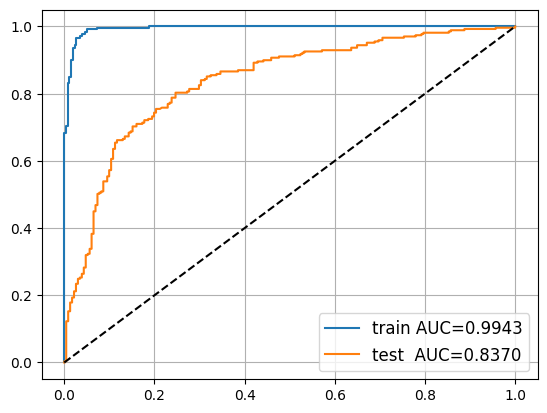

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy >= 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

### Задача: реализовать TF-IDF

Не все слова одинаково полезны. Приоритет редких слов и снижение значимости таких слов, как «и»/«или», можно определить с помощью __tf-idf-функций__.

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


где x - отдельный текст, D - ваш набор данных (коллекция текстов), N - общее количество документов, а $\alpha$ - гиперпараметр сглаживания (обычно 1).
А $Count(word_i \in D)$ - это количество документов, в которых встречается $word_i$.

Также может быть хорошей идеей нормализовать каждую выборку данных после вычисления tf-idf признаков.

__Ваша задача:__ реализовать tf-idf признаки, обучить модель и оценить ROC-кривую. Сравните ее с базовой моделью BagOfWords, приведенной выше.

Пожалуйста, не используйте встроенные в sklearn/nltk векторизаторы tf-idf признаков в вашем решении :) Однако вы можете использовать их для отладки.

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Решение лучше: Эмбеддинги

Попробуем другой подход: вместо того, чтобы считать частоты отдельных слов, мы преобразуем все слова в предобученные векторы слов и усредним их, чтобы получить признаки текста.

Это должно дать нам два ключевых преимущества: (1) у нас теперь будет 10^2 признаков вместо 10^4 и (2) наша модель сможет обобщать слова, которые отсутствуют в тренировочном наборе данных. (ведь мы используем fasttext, который по факту - word2vec на n-grams

Мы начнем со стандартного подхода с предобученными векторами слов. Однако, вы также можете попробовать:
* обучение эмбеддингов с нуля на соответствующих (неразмеченных) данных
* умножение векторов слов на обратную частоту слова в наборе данных (как tf-idf)
* объединение нескольких эмбеддингов
    * вызовите `gensim.downloader.info()['models'].keys()`, чтобы получить список доступных моделей

__Примечание:__ загрузка предобученной модели может занять некоторое время. Это отличная возможность налить себе еще чаю/кофе и взять пару печенек с конфетками

In [42]:
%pip install --upgrade gensim
import gensim.downloader
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts.

Note: you may need to restart the kernel to use updated packages.


In [43]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vector_size
    features = np.zeros([embedding_dim], dtype='float32')

    for token in comment.split():
        if token in embeddings:
            features += embeddings[token]
        else:
            continue

    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [44]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

/home/german/nlp/2_HW/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


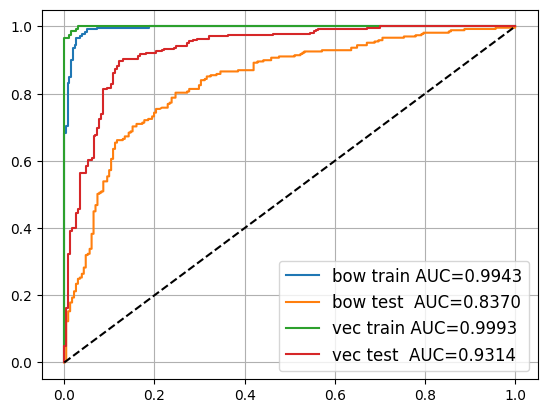

In [45]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

Если все прошло правильно, то вы снизили ошибку в 2 раза.
Этот трюк очень полезен, когда вы имеете дело с небольшими наборами данных.

Однако если у вас сотни тысяч примеров, то для этого существует совершенно другой набор методов. Об этом собсна и далее

### ЛР. Часть II: Large scale text analysis with deep learning (4 points)


**Для успешной сдачи этой части ЛР - нужно получить MAE < 0.11**

За датасет спасибо [Oleg Vasilev](https://github.com/Omrigan/)

Мы будем предсказывать ЗП по резюме. Начнем с семинара, закончим ЛР.

**Для успешной сдачи этой части ЛР - нужно получить MAE < 0.11**

In [46]:
%pip install pandas matplotlib scikit-learn nltk numpy torch requests
%pip install --upgrade gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Начало

Сначала разумеется нужно скачать датасет с яндекс диска.

Данные сделаны на основе Kaggle соревнования - https://www.kaggle.com/c/job-salary-prediction/data


In [47]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [48]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


Одна из проблем с предсказанием зарплат заключается в том, что они распределены необычным образом (хотя кто слушал лекции по классик мл было все идеально): существует много людей, которые получают стандартные зарплаты, и немного тех, кто зарабатывает огромные суммы. Распределение имеет "жирный хвост" на правой стороне, что неудобно для минимизации MSE.

Существует несколько методов для решения этой проблемы: использование другой функции потерь (MSLE), предсказание логарифма целевой переменной вместо исходного значения (LOG1P), или даже замена целевых значений их процентилями среди всех зарплат в обучающем наборе (ДИСКРЕТИЗАЦИЯ????).

Для простоты и вашего интереса буду юзать log1p

_Подробнее можно прочитать [в официальном описании](https://www.kaggle.com/c/job-salary-prediction#description)._

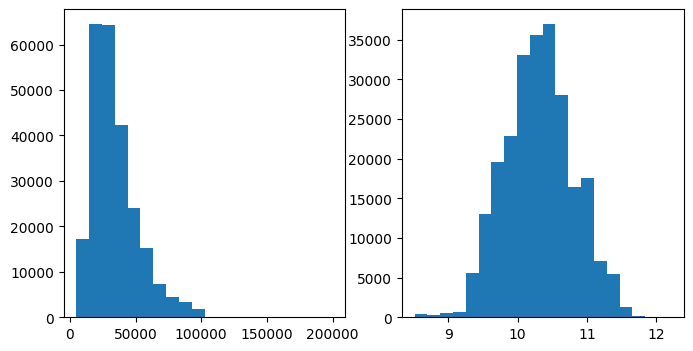

In [49]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Наша задача — предсказать одно число, __Log1pSalary__.

Для этого наша модель может использовать несколько признаков:
* Текстовые данные: __`Title`__ и  __`FullDescription`__
* Категориальные данные: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__ и __`ContractTime`__.

In [50]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
220965,72377505,Head of Group Reporting,I am currently searching for a high calibre qu...,London,London,NaN,permanent,Hays Senior Finance,Accounting & Finance Jobs,75000.00 to 85000.00,80000,tntjobs.co.uk,11.289794
157459,71109956,Theatre Practitioner Recovery & Anaesthetics,"Due to an increase in activity our client, a p...","London, England",London,NaN,permanent,NaN,Healthcare & Nursing Jobs,29000 - 31000 per annum,30000,jobs.telegraph.co.uk,10.308986
234847,72539608,EngD Studentship,Power and signal cables contribute to the mass...,Midlands of England,UK,NaN,NaN,University of Warwick,Teaching Jobs,"19,000 . stipend",19000,Jobs Ac,9.852247


### Препроцессинг

Как и на прошлой неделе, NLP начинается с токенизации: разбиения исходного текста на последовательности токенов (слов, знаков пунктуации и т.д.).

__Ваша задача__ — привести к нижнему регистру и токенизировать все тексты в столбцах `Title` и `FullDescription`. Сохраните токенизированные данные в виде строки с токенами, разделенными __пробелами__, для повышения производительности.


In [51]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [52]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE
# Приводим к нижнему регистру и токенизируем
data['FullDescription'] = data['FullDescription'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))
data['Title'] = data['Title'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))

Теперь мы можем предположить, что наш текст - это список лексем, разделенных пробелами:

In [53]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Не все слова одинаково полезны. Некоторые из них - опечатки или редкие слова, которые встречаются всего несколько раз.

Давайте подсчитаем, сколько раз каждое слово встречается в данных, чтобы составить «белый список» известных слов.

In [54]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>
# Объединяем все токены из "Title" и "FullDescription"
for tokens in data['Title']:
    token_counts.update(tokens.split())

for tokens in data['FullDescription']:
    token_counts.update(tokens.split())

In [55]:
token_counts.most_common(1)[0][1]

2657388

In [56]:
len(token_counts)

202704

In [57]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


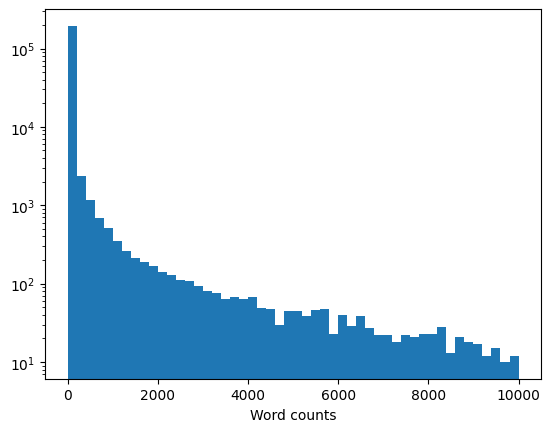

In [58]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Задание 1.1__ Получите список всех токенов, которые встречаются не менее 10 раз.

In [59]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [60]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Задача 1.2__ Постройте обратный индекс токена: словарь от токена(string) до его индекса в `tokens` (int)

In [61]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [64]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [65]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [66]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Теперь давайте закодируем имеющиеся у нас категориальные данные.

Для простоты мы будем использовать кодировку one-hot. Но естесна тот же tfidf даст качество выше

In [67]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

,dtype,<class 'numpy.float32'>
,separator,'='
,sparse,False
,sort,True


### DL Part (Хелло Д.В. Сош.)

После того как мы научились токенизировать данные, давайте подкрадемся к машинному обучению.

Для простоты - обычный train test split

In [68]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


ЕСТЬ ВОПРОСИК!!!

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [70]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[   18,   287,   359,     1,     1,     1,     1],
         [ 2863,    11,    12,    13,    55,    37, 12109],
         [ 2833,   618,   858,    63,  7104,  7105,    64]], device='cuda:0'),
 'FullDescription': tensor([[   18,   287,   359,  1408,   561,    18,   287,   359,  1464,  1408],
         [ 2863,    11,    12,    13,    55,    37, 12109,  1767,  1166,    74],
         [  142,  1617,  8830,  1314,  1464,   559,   560,   561,   618,   858]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Архитектура

Наша базовая модель состоит из трех частей:
* Title Encoder
* Description encoder
* Categorical features encoder

Затем мы объединим все 3 реза в одну сетку, которая предсказывает зарплату.



<img src="https://i.imgur.com/yP8CgVK.png" alt="Image" width="400"/>

In [71]:
class SalaryPredictor(nn.Module):
    def __init__(
        self,
        n_tokens: int = len(tokens),
        n_cat_features: int = len(categorical_vectorizer.vocabulary_),
        hid_size: int = 64,
        pad_ix: int = PAD_IX,
    ):
        super().__init__()
        # token embedding
        self.token_emb = nn.Embedding(n_tokens, hid_size, padding_idx=pad_ix)
        # project categorical one-hot / count features into hid_size
        self.cat_lin = nn.Linear(n_cat_features, hid_size)
        # combine title, description and cat into hidden
        self.fc1 = nn.Linear(hid_size * 3, hid_size)
        # final regression output
        self.fc2 = nn.Linear(hid_size, 1)
        self.pad_ix = pad_ix

    def forward(self, batch: dict) -> torch.Tensor:
        """
        batch["Title"]:        LongTensor [B, L1]
        batch["FullDescription"]: LongTensor [B, L2]
        batch["Categorical"]:  FloatTensor [B, n_cat]
        returns: FloatTensor [B] of salary predictions
        """
        title_ids = batch["Title"]
        desc_ids  = batch["FullDescription"]
        cat_feats = batch["Categorical"]

        # embed and mask-out pads, then average
        def avg_embed(ids: torch.LongTensor):
            emb = self.token_emb(ids)                                # [B, L, H]
            mask = (ids != self.pad_ix).unsqueeze(-1).float()        # [B, L, 1]
            summed = (emb * mask).sum(dim=1)                         # [B, H]
            lengths = mask.sum(dim=1).clamp(min=1.0)                 # [B, 1]
            return summed / lengths                                  # [B, H]

        title_vec = avg_embed(title_ids)                             # [B, H]
        desc_vec  = avg_embed(desc_ids)                              # [B, H]
        cat_vec   = F.relu(self.cat_lin(cat_feats))                  # [B, H]

        # concatenate and MLP
        x = torch.cat([title_vec, desc_vec, cat_vec], dim=1)         # [B, 3H]
        x = F.relu(self.fc1(x))                                      # [B, H]
        out = self.fc2(x).squeeze(-1)                                # [B]
        return out



In [72]:
model = SalaryPredictor()

In [73]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Обучение и оценка

Как обычно, мы будем кормить нашего монстра случайными минибатчами данных.

В процессе обучения мы хотим отслеживать не только функцию потерь, которая вычисляется в логарифмическом пространстве, но и фактическую ошибку, измеряемую в долларах.

In [74]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

## Обучение модели (И ОСНОВНЫЕ ИДЕИ)

Теперь мы можем подогнать нашу модель под обычные минибатчи. Забавность в том, что мы обучаемся на бесконечном потоке минибатчей, создаваемых функцией `iterate_minibatches`. Экономия памяти, ю ноу?


Главная задача - использовать некоторые трюки, которым мы научились и проанализировать, можете ли вы улучшить __validation MAE__. Попробуйте __как минимум 3 варианта__, напишите репорт и добейтесь MAE < 0.11. Больше идей (и реализаций) = больше бонусных баллов.

__Только все делаем нормально:__ постройте кривые обучения в MAE/epoch, сравните результаты обучения / метрик моделей друг с другом

Вы можете использовать как __pytorch__ или __tensorflow__, так и любой другой фреймворк (например, чистый __keras__). Не стесняйтесь адаптировать код семинара под свои нужды.

## Рекомендуемые варианты

#### A) Архитектура CNN

Все известные трюки, связанные с полносвязными и сверточными нейронными сетями, применимы и здесь:
* Dropout. Без комментариев.
* Batch Norm. В этот раз используем `nn.BatchNorm*`/`L.BatchNormalization`.
* Параллельные сверточные слои. Идея заключается в том, чтобы применить несколько `nn.Conv1d` к одним и тем же эмбеддингам и объединить выходные каналы.
* Больше слоев, больше нейронов, как обычно...

#### B) Эксперименты с пулингом

Существует несколько способов пулинга:
* Max pooling
* Mean pooling
* Softmax pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } } $$

* Attentive pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$,
а $NN_{attn}$ — это полносвязный слой.

Оптимальные результаты обычно достигаются путем объединения нескольких различных видов пулинга, включая несколько Attentive pooling с разными $NN_{attn}$.


#### C) Работа со словами

Не всегда разумно обучать эмбеддинги с нуля. Вот несколько приемов:

* Используйте предобученные эмбеддинги из `gensim.downloader.load`. См. последнюю лекцию.
* Начните с предобученных эмбеддингов, а затем дообучайте их с помощью градиентного спуска. Вы можете загрузить предобученные эмбеддинги, например, [отсюда](http://nlp.stanford.edu/data/glove.6B.zip)
* Используйте одну и ту же матрицу эмбеддингов для векторизаторов заголовков и описаний.

#### D) Использование рекуррентных сетей

Мы уже узнали, что рекуррентные сети могут быть полезны в моделировании последовательностей. Оказывается, они могут быть полезны и для классификации, с некоторыми хитростями...

* Как и в случае со сверточными слоями, выход LSTM следует свести к вектору фиксированного размера с помощью одного из пулингов.
* Поскольку вы заранее знаете весь текст, используйте двунаправленную RNN:
  * Запустите одну LSTM слева направо.
  * Запустите другую параллельно справа налево.
  * Объедините их выходные последовательности по оси единиц (dim=-1).

* Возможно, хорошей идеей будет смешать сверточные и рекуррентные слои для заголовков и описаний.

#### E) Серьезная оптимизация

* Не обязательно тренировать модель 100 эпох. Используйте раннюю остановку (early stopping). Если вы никогда этого не делали, взгляните на [callback ранней остановки в Keras](https://keras.io/callbacks/#earlystopping) или в [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * В двух словах, тренируйте модель до тех пор, пока валидация не начнет ухудшаться.
  * Сохраняйте лучший по валидации снимок модели через `model.save(file_name)`.

Удачи! И да пребудет с вами сила!

In [75]:
from tqdm.auto import tqdm

BATCH_SIZE = 32
EPOCHS = 30

/home/german/nlp/2_HW/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class SalaryCNNPredictorWithALL(nn.Module):
    def __init__(self, 
        n_tokens: int = len(tokens),
        n_cat_features: int = len(categorical_vectorizer.vocabulary_),
        hid_size: int = 256
        ):
        super().__init__()

        self.emb = nn.Embedding(n_tokens, 320)

        self.conv_title = nn.Conv1d(self.emb.embedding_dim, self.emb.embedding_dim*2, kernel_size=3)
        self.conv_desc = nn.Conv1d(self.emb.embedding_dim, self.emb.embedding_dim*2, kernel_size=3)

        self.act = nn.ReLU()

        self.encoder_cat = nn.Linear(n_cat_features, hid_size)
        
        self.output = nn.Linear(1536, 1)
        
    def forward(self, batch):
        title = self.emb(batch['Title']).transpose(-1, -2)
        title = self.conv_title(title)
        title = self.act(title)
        title = title.max(dim=2).values

        desc = self.emb(batch['FullDescription']).transpose(-1, -2)
        desc = self.conv_desc(desc)
        desc = self.act(desc)
        desc = desc.max(dim=2).values


        cat = self.encoder_cat(batch["Categorical"])

        concat = torch.concat([title,desc,cat], dim=1)

        return self.output(concat).squeeze(1)

In [93]:
import torch
import torch.nn as nn
from gensim.models import KeyedVectors
import gensim.downloader as api
import warnings

class SalaryHybridPredictor(nn.Module):
    def __init__(self, 
        n_tokens=len(token_to_id),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size: int = 128,
        conv_hid: int = 128,
        lstm_hid: int = 64,
        embedding_dim: int = 300,
        freeze_embeddings: bool = True,
        dropout_rate: float = 0.3
        ):
        super().__init__()
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                w2v = api.load("glove-wiki-gigaword-300")
            except:
                print("Downloading embeddings...")
                w2v = api.load("glove-wiki-gigaword-300")
        
        weights = torch.zeros(n_tokens, embedding_dim)
        found_count = 0
        
        for word, idx in token_to_id.items():
            if word in w2v.key_to_index:
                weights[idx] = torch.FloatTensor(w2v[word])
                found_count += 1
            else:

                weights[idx] = torch.normal(0, 0.1, size=(embedding_dim,))
        
        print(f"Embeddings coverage: {found_count/len(token_to_id):.2%}")
        
        self.emb = nn.Embedding.from_pretrained(
            weights, 
            freeze=freeze_embeddings,
            padding_idx=0
        )
        

        self.emb_dropout = nn.Dropout(dropout_rate)
        
        self.kernel_sizes = [2, 3, 4, 5]
        
        self.conv_layers = nn.ModuleList()
        for ks in self.kernel_sizes:
            conv_block = nn.Sequential(
                nn.Conv1d(embedding_dim, conv_hid, ks, padding='same'),
                nn.BatchNorm1d(conv_hid),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.AdaptiveMaxPool1d(1)
            )
            self.conv_layers.append(conv_block)
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=lstm_hid,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate
        )
        self.lstm_bn = nn.BatchNorm1d(lstm_hid * 4)  # bidirectional * 2 текста
        
        self.title_gate = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.Sigmoid()
        )
        self.desc_gate = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.Sigmoid()
        )
        
        self.cat_processor = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hid_size * 2, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU()
        )
        
        conv_output_size = conv_hid * len(self.kernel_sizes)
        lstm_output_size = lstm_hid * 4  # bidirectional * 2 текста
        total_features = conv_output_size + lstm_output_size + hid_size
        
        self.output_net = nn.Sequential(
            nn.Linear(total_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hid_size * 2, 1)
        )
        
    def forward(self, batch):
        title_emb = self.emb(batch['Title'])
        desc_emb = self.emb(batch['FullDescription'])
        
        title_gate = self.title_gate(title_emb.mean(dim=1))
        desc_gate = self.desc_gate(desc_emb.mean(dim=1))
        
        combined_emb = torch.cat([
            title_emb * title_gate.unsqueeze(1),
            desc_emb * desc_gate.unsqueeze(1)
        ], dim=1)
        
        conv_features = []
        conv_input = combined_emb.permute(0, 2, 1)  # [batch, emb, seq]
        
        for conv_layer in self.conv_layers:
            features = conv_layer(conv_input)
            conv_features.append(features.squeeze(-1))
        
        conv_output = torch.cat(conv_features, dim=1)
        
        title_lstm, _ = self.lstm(title_emb)
        desc_lstm, _ = self.lstm(desc_emb)
        
        title_lstm = title_lstm[:, -1, :]
        desc_lstm = desc_lstm[:, -1, :]
        lstm_output = self.lstm_bn(torch.cat([title_lstm, desc_lstm], dim=1))
        
        cat_features = self.cat_processor(batch["Categorical"])
        
        combined_features = torch.cat([conv_output, lstm_output, cat_features], dim=1)
        
        return self.output_net(combined_features).squeeze(1)

In [94]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            batch_target = batch[TARGET_COLUMN]
            squared_error += torch.sum(torch.square(batch_pred - batch_target))
            abs_error += torch.sum(torch.abs(batch_pred - batch_target))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [ ]:
model = SalaryCNNPredictorWithALL().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print_metrics(model, data_val, device=device)



epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

6120it [03:24, 29.99it/s]                          


 results:
Mean square error: 0.07695
Mean absolute error: 0.21058
epoch: 1


6120it [03:24, 29.94it/s]                          


 results:
Mean square error: 0.07397
Mean absolute error: 0.20909
epoch: 2


6120it [03:25, 29.84it/s]                          


 results:
Mean square error: 0.06025
Mean absolute error: 0.18292
epoch: 3


6120it [03:25, 29.84it/s]                          


### Бонусная часть: объяснение предсказаний модели

Обычно полезно понять, как работает модель, прежде чем позволить ей принимать решения в проде.

Для линейных моделей это просто: достаточно посмотреть, какие слова приобрели положительные или отрицательные веса. Однако гораздо сложнее с нейронными сетями, которые учатся сложным нелинейным зависимостям.

Однако есть несколько способов заглянуть внутрь «черного ящика»:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Сегодня мы попробуем первый метод, просто потому что он самый простой.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 131617
Salary (gbp): tensor([95797.3984])


project director energy from waste

we are currently recruiting a project director for the leading epc / principal contractor in the energy from waste market . the business operates across the world and is currently building a number of facilities at the moment for clients . whilst the majority of their work is won on competitive tender they are the preferred contractor to the vast number of waste companies . because of an increase in projects in europe they are now looking to appoint an experienced and knowledgeable project director to oversee the successful delivery of efw plants . they are looking to speak with experienced energy from waste professionals who are degree educated in engineering and have intimate project experience on efw plants . reporting into the group construction director you will be based both on site and hq but oversee the projects being built in the uk . you will recruit a train a project team and ideally be able to bring engineers from previous projects together . with the worldwide market for efw picking up due to an increase in renewable energy projects this is an exciting time to join the business . key skills / experiences must have experience in delivering large energy from waste projects . background of working for large international epc / main contractors . experience of delivering construction projects in the uk . have excellent written and spoken english . must be degree qualified engineer ; ideally also have msc or mba . previous experience of multidisciplinary project management at director level . a good knowledge of the european waste industry . any candidate considering this role will have to travel across the uk , location is not key but you will spend large parts of time away from home . please note that unless you meet the above criteria your UNK will not be taken further . this job was originally posted as www . careerstructure . com / jobseeking / UNK ****